<a href="https://colab.research.google.com/github/sjnaj/DeepLearning/blob/master/Basic/cudaTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon May  9 18:23:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
from torch import nn

torch.device('cpu'),torch.cuda.device('cuda'),torch.cuda.device('cuda:1')#默认是cuda0



(device(type='cpu'),
 <torch.cuda.device at 0x7fac47159250>)

In [4]:
torch.cuda.device_count()

1

In [5]:
def try_gpu(i=0):  
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus(): 
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(),try_gpu(10),try_all_gpus()


(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

In [6]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

In [7]:
X = torch.ones(2, 3, device=try_gpu())
X

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

In [8]:
X.cuda(0)==X

tensor([[True, True, True],
        [True, True, True]], device='cuda:0')

In [9]:
# Z = X.cuda(1)#只有1个不能运行
# print(X)
# print(Z)
Z=X.cuda(0)
X+Z

tensor([[2., 2., 2.],
        [2., 2., 2.]], device='cuda:0')

In [10]:
net = nn.Sequential(nn.Linear(3, 1))
net = net.to(device=try_gpu())
net(X)

tensor([[-0.0775],
        [-0.0775]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [11]:
net[0].weight.data.device#net里的参数都在cuda0上


device(type='cuda', index=0)

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-oqhb0o6h
  Running command git clone -q https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-oqhb0o6h
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 15.7 MB 5.1 MB/s 
     |████████████████████████████████| 11.2 MB 32.2 MB/s 
     |████████████████████████████████| 61 kB 5.1 MB/s 
     |████████████████████████████████| 9.9 MB 31.0 MB/s 
     |████████████████████████████████| 930 kB 53.9 MB/s 
  Created wheel for d2l: filename=d2l-2.0.0b0-py3-none-any.whl size=80152 sha256=af7a876790644584fe93873aa8082064a9f314c17b0fe55815d664d5599a9296
  Stored in directory: /tmp/pip-ephem-wheel-cache-ia8q3hzd/wheels/73/f4/42/d2b85ca46d85a241d6aa57c1c24027de2d2258202bb67945f9
Successfully b

DataLoader改进

1,non_blocking默认值为False, 通常我们会在加载数据时，将DataLoader的参数pin_memory设置为True, DataLoader中参数pin_memory的作用是：将生成的Tensor数据存放在哪里，值为True时，意味着生成的Tensor数据存放在锁页内存中，这样内存中的Tensor转义到GPU的显存会更快。
主机中的内存，有两种存在方式，一是锁页，二是不锁页，锁页内存存放的内容在任何情况下都不会与主机的虚拟内存进行交换（注：虚拟内存就是硬盘），而不锁页内存在主机内存不足时，数据会存放在虚拟内存中。显卡中的显存全部是锁页内存,当计算机的内存充足的时候，可以设置pin_memory=True。当系统卡住，或者交换内存使用过多的时候，设置pin_memory=False。
如果pin_memory=True的话，将数据放入GPU的时候，也应该把non_blocking打开，这样就只把数据放入GPU而不取出，访问时间会大大减少。

2,也可以使用data_prefetcher，多了cuda.stream便于向gpu传送数据，对于本例有反作用，应该是colab不支持Device Overlap

CUDA流表示一个GPU操作队列，该队列中的操作将以添加到流中的先后顺序而依次执行。可以将一个流看做是GPU上的一个任务，不同任务可以并行执行。使用CUDA流，首先要选择一个支持设备重叠（Device Overlap）功能的设备，支持设备重叠功能的GPU能够在执行一个CUDA核函数的同时，还能在主机和设备之间执行复制数据操作。


支持重叠功能的设备的这一特性很重要，可以在一定程度上提升GPU程序的执行效率。一般情况下，CPU内存远大于GPU内存，对于数据量比较大的情况，不可能把CPU缓冲区中的数据一次性传输给GPU，需要分块传输，如果能够在分块传输的同时，GPU也在执行核函数运算，这样的异步操作，就用到设备的重叠功能，能够提高运算性能。

3,最快的方式是用dataload解开全部加载到list，缺点是可会导致内存爆掉,可通过增大swap来避免(colab不允许)，也可以考虑用yield将dataloader分段然后转存,过程中用del和gc清除不用的数据
激活函数开启inplace对内存节省也很有效果

第二种办法

In [13]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）

    Defined in :numref:`sec_softmax_scratch`"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    prefetcher = data_prefetcher(train_iter)
    X,y=prefetcher.next()
    while X is not None:
      # 计算梯度并更新参数
      if torch.cuda.is_available():
        X=X.cuda()
        y=y.cuda()
      y_hat = net(X)
      l = loss(y_hat, y)
      if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
        updater.zero_grad()
        l.mean().backward()
        updater.step()
      else:
            # 使用定制的优化器和损失函数
        l.sum().backward()
        updater(X.shape[0])
      metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
      X,y=prefetcher.next()

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度

    Defined in :numref:`sec_softmax_scratch`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数

    with torch.no_grad():
        prefetcher = data_prefetcher(train_iter)
        X,y=prefetcher.next()
        while X is not None:
          if torch.cuda.is_available():
            X=X.cuda()
            y=y.cuda()
          metric.add(d2l.accuracy(net(X), y), d2l.size(y))
          X,y=prefetcher.next()

    return metric[0] / metric[1]
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):#调整一下ylim
    """训练模型（定义见第3章）
    Defined in :numref:`sec_softmax_scratch`"""


    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0., 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
      #调整下面两个函数使其可以使用cuda（修改iter迭代时的X，y）
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [14]:
import torchvision
from torch.utils import data
from torchvision import transforms

def get_dataloader_workers():
    """使用4个进程来读取数据

    Defined in :numref:`sec_fashion_mnist`"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))
   # pin_memory If True, the data loader will copy Tensors into CUDA pinned memory before returning them

In [15]:
class data_prefetcher():
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        # self.mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1)
        # self.std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1)
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(non_blocking=True)
            self.next_target = self.next_target.cuda(non_blocking=True)
            self.next_input = self.next_input.float()
            # self.next_input = self.next_input.sub_(self.mean).div_(self.std)#标准化（RGB数据使用）
            
    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        self.preload()#返回一次即进行preload
        return input, target

Traceback (most recent call last):
  File "<ipython-input-17-3d98b202bbcc>", line 35, in <module>
    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
  File "<ipython-input-13-0b369042b461>", line 62, in train_ch3
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
  File "<ipython-input-13-0b369042b461>", line 29, in train_epoch_ch3
    X,y=prefetcher.next()
  File "<ipython-input-15-d434eaf1a6e3>", line 26, in next
    self.preload()#返回一次即进行preload
  File "<ipython-input-15-d434eaf1a6e3>", line 11, in preload
    self.next_input, self.next_target = next(self.loader)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 530, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1207, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1173, in _get_data
    success, data =

KeyboardInterrupt: ignored

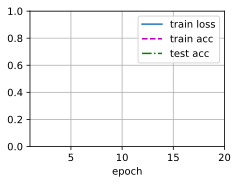

In [17]:
from d2l import torch as d2l
import torch
from torch import nn
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
# train_iter=list(train_iter)
# print(len(train_iter))
# test_iter=list(test_iter)
# print(type(train_iter))
net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs,num_hiddens1),
    nn.ReLU(),
    #在第一个全连接层后加一个dropout
    nn.Dropout(dropout1),
    nn.Linear(num_hiddens1,num_hiddens2),
    nn.ReLU(),
    #在第二个全连接层后面加一个dropout
    nn.Dropout(dropout2),
    nn.Linear(num_hiddens2,num_outputs)
    )
net=net.to(device=d2l.try_gpu())
loss=loss.to(device=d2l.try_gpu())

trainer = torch.optim.SGD(net.parameters(), lr=lr)
print(net,net[1].weight.data.device)

import traceback
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
  try:

    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
  except:
    traceback.print_exc()

print(prof.key_averages().table(sort_by="self_cpu_time_total",row_limit=10))#按gpu占用排序，也可调整为cuda

   


In [ ]:
#!pip install wandb

In [ ]:
# import wandb#实时查看资源占用
# wandb.init()


第一种方式

In [1]:
import torchvision
from torch.utils import data
from torchvision import transforms

def get_dataloader_workers():
    """使用4个进程来读取数据

    Defined in :numref:`sec_fashion_mnist`"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers(),pin_memory=True),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers(),pin_memory=True))
   # pin_memory If True, the data loader will copy Tensors into CUDA pinned memory before returning them

In [2]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）

    Defined in :numref:`sec_softmax_scratch`"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = d2l.Accumulator(3)
    for X,y in train_iter:
      # 计算梯度并更新参数
      if torch.cuda.is_available():
        X=X.cuda(non_blocking=True)
        y=y.cuda(non_blocking=True)
      y_hat = net(X)
      l = loss(y_hat, y)
      if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
        updater.zero_grad()
        l.mean().backward()
        updater.step()
      else:
            # 使用定制的优化器和损失函数
        l.sum().backward()
        updater(X.shape[0])
      metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度

    Defined in :numref:`sec_softmax_scratch`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = d2l.Accumulator(2)  # 正确预测数、预测总数

    with torch.no_grad():
        
        for X,y in data_iter:

          if torch.cuda.is_available():
            X=X.cuda(non_blocking=True)
            y=y.cuda(non_blocking=True)
          metric.add(d2l.accuracy(net(X), y), d2l.size(y))

    return metric[0] / metric[1]
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):#调整一下ylim
    """训练模型（定义见第3章）
    Defined in :numref:`sec_softmax_scratch`"""


    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0., 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
      #调整下面两个函数使其可以使用cuda（修改iter迭代时的X，y）
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [3]:
from d2l import torch as d2l
import torch
from torch import nn
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
# train_iter=list(train_iter)
# print(len(train_iter))
# test_iter=list(test_iter)
# print(type(train_iter))
net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs,num_hiddens1),
    nn.ReLU(),
    #在第一个全连接层后加一个dropout
    nn.Dropout(dropout1),
    nn.Linear(num_hiddens1,num_hiddens2),
    nn.ReLU(),
    #在第二个全连接层后面加一个dropout
    nn.Dropout(dropout2),
    nn.Linear(num_hiddens2,num_outputs)
    )
#默认的初始化效果更好
# def init_weights(m):
#   if type(m)==nn.Linear:
#     nn.init.normal_(m.weight,std=0.01)

# net.apply(init_weights)
net=net.to(device=d2l.try_gpu())
loss=loss.to(device=d2l.try_gpu())

trainer = torch.optim.SGD(net.parameters(), lr=lr)
print(net,net[1].weight.data.device)

import traceback
with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
  try:

    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
  except:
    traceback.print_exc()

print(prof.key_averages().table(sort_by="self_cpu_time_total",row_limit=10))#按gpu占用排序，也可调整为cuda

   


Traceback (most recent call last):
  File "<ipython-input-3-2faa4ca15ab7>", line 41, in <module>
    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
  File "<ipython-input-2-351075db6c14>", line 58, in train_ch3
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
  File "<ipython-input-2-351075db6c14>", line 20, in train_epoch_ch3
    l.mean().backward()
  File "/usr/local/lib/python3.7/dist-packages/torch/_tensor.py", line 363, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py", line 175, in backward
    allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f708803d3b0> (for post_execute):


KeyboardInterrupt: ignored

第三种方式

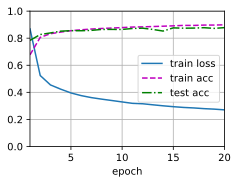

In [5]:
from d2l import torch as d2l
import torch
from torch import nn
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_iter=list(train_iter)
print(len(train_iter))
test_iter=list(test_iter)
print(type(train_iter))
net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs,num_hiddens1),
    nn.ReLU(inplace=True),
    #在第一个全连接层后加一个dropout
    nn.Dropout(dropout1),
    nn.Linear(num_hiddens1,num_hiddens2),
    nn.ReLU(inplace=True),
    #在第二个全连接层后面加一个dropout
    nn.Dropout(dropout2),
    nn.Linear(num_hiddens2,num_outputs)
    )
# 默认的初始化效果更好
# def init_weights(m):
#   if type(m)==nn.Linear:
#     nn.init.normal_(m.weight,std=0.01)

# net.apply(init_weights)
net=net.to(device=d2l.try_gpu())
loss=loss.to(device=d2l.try_gpu())

trainer = torch.optim.SGD(net.parameters(), lr=lr)
print(net,net[1].weight.data.device)

import traceback
try:

    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except:
    traceback.print_exc()
#资源计算消耗时间过大，用时再开
# with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
#   try:

#     train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
#   except:
#     traceback.print_exc()

# print(prof.key_averages().table(sort_by="self_cpu_time_total",row_limit=10))#按gpu占用排序，也可调整为cuda

   


加一个RRelu

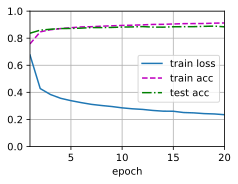

In [6]:
from d2l import torch as d2l
import torch
from torch import nn
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
num_epochs, lr, batch_size = 20, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_iter=list(train_iter)
print(len(train_iter))
test_iter=list(test_iter)
print(type(train_iter))
net=nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_inputs,num_hiddens1),
    nn.ReLU(inplace=True),
    #在第一个全连接层后加一个dropout
    nn.Dropout(dropout1),
    nn.Linear(num_hiddens1,num_hiddens2),
    nn.RReLU(inplace=True),
    #在第二个全连接层后面加一个dropout
    nn.Dropout(dropout2),
    nn.Linear(num_hiddens2,num_outputs)
    )


# def init_weights(m):
#   if type(m)==nn.Linear:
#     nn.init.xavier_normal_(m.weight,std=0.01)

# net.apply(init_weights)
net=net.to(device=d2l.try_gpu())
loss=loss.to(device=d2l.try_gpu())

trainer = torch.optim.Adam(net.parameters())#SGD优化版，lr要较小，采用默认的0.001
print(net,net[1].weight.data.device)

import traceback
# with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
try:

    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
except:
    traceback.print_exc()

# print(prof.key_averages().table(sort_by="self_cpu_time_total",row_limit=10))#按gpu占用排序，也可调整为cuda

   


In [ ]:
d =[]
while(1):
  d.append('1')
#让ram达到上限从而实现清空